# Plotting a HR Diagram of Stars with Gala

## Authors
This tutorial is based on "Computing Galactic Orbits of Stars with Gala" by Adrian Price-Whelan, Stephanie T. Douglas. 

Modified for ASTR341 at Haverford College to use Gaia DR3, and to be about plotting HR diagrams, and cross matching stars by KLM 

## Learning Goals
* Query the Gaia data release 3 catalog to retrieve data for a sample of well-measured, nearby stars
* Plot a HR diagram
* Learn how to do a cross match a small sample of stars to extract their Gaia information. 

## Companion Content

## Summary

We will use data from the [Gaia mission](https://www.cosmos.esa.int/web/gaia) to get sky positions, distances (parallaxes), luminosities and colour for a set of stars that are close to the Sun. 

We will also learn how to import a table of stars and cross match with Gaia. 

## Installing Dependencies

This tutorial depends on the Astropy affiliated package `astroquery`. Try running the imports to see if you have this. If you don't it can be pip-installed with:

    pip install astroquery

## Imports

In [1]:
# astropy imports
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.table import QTable
import astropy.units as u
from astroquery.gaia import Gaia
from astropy.io import ascii
from astropy.table import Table

# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Scientific Background

[The Gaia mission](https://www.cosmos.esa.int/web/gaia/) is an ESA mission that aims to measure the 3D positions and velocities of a large number of stars throughout the Milky Way. The primary mission objective is to enable studying the formation, structure, and evolutionary history of our Galaxy by measuring astrometry (sky position, parallax, and proper motion) for about 2 billion stars brighter than the Gaia $G$-band photometric magnitude $G \lesssim 21$. By end of mission (~2022), Gaia will also provide multi-band photometry and low-resolution spectrophotometry for these sources, along with radial or line-of-sight velocities for a subsample of about 100 million stars.

## 1. Using `astroquery` to retrieve Gaia data

We'll start by querying the [Gaia science archive](http://gea.esac.esa.int/archive/) to download magnitudes and distances (parallax) for a sample of stars near the Sun. We'll use data exclusively from [data release 3 (DR3)](https://www.cosmos.esa.int/web/gaia/data-release-3) from the *Gaia* mission. For the demonstration here, let's grab data for a random subset of 4096 stars within a distance of 100 pc (or with a parallax > 10 mas) from the Sun that have high signal-to-noise astrometric measurements.

```STOP: do you remember what parallax is? If not look it up now. ```

To perform the query and to retrieve the data, we'll use the *Gaia* module in the [astroquery](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html) package, `astroquery.gaia`. This module expects us to provide an SQL query to select the data we want (technically it should be an [ADQL](https://gea.esac.esa.int/archive-help/adql/index.html) query, which is similar to SQL but provides some additional functionality for astronomy; to learn more about ADQL syntax and options, [this guide](https://www.gaia.ac.uk/data/gaia-data-release-1/adql-cookbook) provides an introduction). We don't need all of the columns that are available in DR3, so we'll limit our query to request the sky position (`ra`, `dec`), parallax, and magnitudes (`phot_*_mean_mag`). More information about the available columns is in the [Gaia DR2 data model](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html). 

To select stars that have high signal-to-noise parallaxes, we'll use the filter ``parallax_over_error > 10`` to select stars that have small fractional uncertainties. 

In [2]:
query_text = '''SELECT TOP 4096 ra, dec, parallax, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr3.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 10
ORDER BY random_index
'''

We now pass this query to the `Gaia.launch_job()` class method to create an anonymous job in the `Gaia` science archive to run our query. To retrieve the results of this query as an Astropy `Table` object, we then use the `job.get_results()` method. Note that you may receive a number of warnings (output lines that begin with ``WARNING:``) from the ``astropy.io.votable`` package — these are expected, and it's OK to ignore these warnings (the `Gaia` archive returns a slightly invalid VOTable).

In [3]:
job = Gaia.launch_job(query_text)
gaia_data = job.get_results()
#gaia_data.write('gaia_data.fits',overwrite=True) #Use this if you want to save the data to a fits file for later use

The `data` object is now an Astropy `Table` called `gaia_data` that contains `Gaia` data for 4096 random stars within 100 pc (or with a parallax > 10 mas) of the Sun, as we requested. Let's look at the first four rows of the table:

In [4]:
gaia_data[:4]

ra,dec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mag,mag,mag
float64,float64,float64,float32,float32,float32
132.10459270933268,2.271051596123523,12.599344304105063,11.123108,11.694805,10.408632
251.09760693925082,-56.960100359866715,11.304311485078195,12.686421,13.5849085,11.753894
264.3976009592568,-48.01172572293079,15.214794611885912,20.677977,20.847157,19.635334
283.11044937721783,-26.150079226853457,12.38950294033803,15.174004,16.662727,13.981808


Note that the table columns already contain units! They are indicated in the second row of the header.

## Checking the Data
Let's double check that the farthest star is still within 100 pc, as we expect from the parallax selection we did in the query above. To do this, we'll create an Astropy `Distance` object using the parallax (*Note: this inverts the parallax to compute the distance! This is only a good approximation when the parallax signal to noise is large, as we ensured in the query above with `parallax_over_error > 10`*):

In [5]:
dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
dist.min(), dist.max()

(<Distance 6.83028711 pc>, <Distance 99.99489826 pc>)

This should return the min and max distances for your sample. 

Another quick check is to plot a histogram of these data. This is easy in python using the below. 

Text(0, 0.5, 'Number of stars')

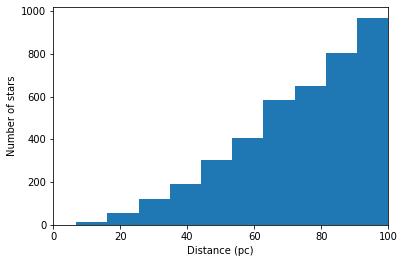

In [6]:
plt.hist(dist.value) #dist is an object with units, use this to get values to plot a histogram. 
plt.xlim(0,100)
plt.xlabel('Distance (pc)')
plt.ylabel('Number of stars')

This should show roughly an increase of the number of stars with distance squared. Why? ADD A COMMENT HERE 

# Sky Plot

Another useful quick check is a sky plot. 

You can literally just plot ra vs. dec, but we'll also set things up correctly in the [Astropy coordinates](http://docs.astropy.org/en/latest/coordinates/index.html) transformation machinery. To make use of this functionality, we first have to create a `SkyCoord` object from the `Gaia` data we downloaded. The `Gaia` DR2 data are in the ICRS (equatorial) reference frame, which is the default frame when creating new `SkyCoord` objects.

In [7]:
c = coord.SkyCoord(ra=gaia_data['ra'], 
                   dec=gaia_data['dec'],
                   distance=dist)

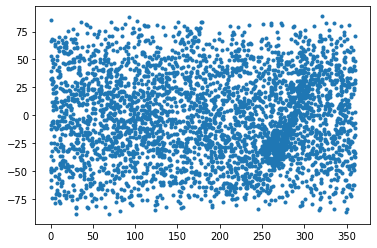

In [8]:
#Here's a really quick sky plot. There are ways to do fancy projects, but KLM didn't have time to look it up now. 
#Play with that if coding is easy for you. Otherwise move on. 
plt.plot(c.ra, c.dec,'.')

## 2. HR Diagram

`Gaia` provides photometric data for three photometric bandpasses: the broad-band `G`, the blue `BP`, and the red `RP` magnitudes. Let's make a Gaia color-magnitude diagram using the $G_{\rm BP}-G_{\rm RP}$ color and the absolute $G$-band magnitude $M_G$. We'll compute the absolute magnitude using the distances we computed earlier — Astropy `Distance` objects have a convenient `.distmod` attribute that provides the distance modulus. 

```If you don't remember what distance modulus is look it up. ```

A color-magnitude diagram is the observers version of a HR diagram. The colour is like the temperature, and the absolute magnitude is a measure of the luminosity. 

You can get an estimate of the temperature using: 
$\log(T_{\rm eff}) = 3.999−0.654(G_{BP}-G_{RP})+0.709(G_{BP}-G_{RP})^2−0.316(G_{BP}-G_{RP})^3$ (Jordi et al. 2010).

PS. I am puzzled that this goes to zero Kelvin... that seems unlikely. I should read the paper more closely. Anyway the idea is there - in principle colour can be converted to surface temperature. 

In [9]:
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']
Teff = 10**(3.999 - 0.654*(BP_RP.value) + 0.709*(BP_RP.value)**2 - 0.316*(BP_RP.value)**3)

Text(0, 0.5, '$M_G$')

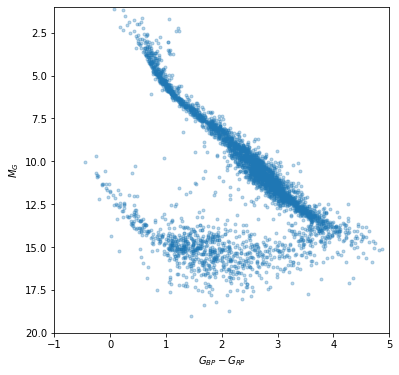

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value, 
        marker='.', linestyle='none', alpha=0.3)

ax.set_xlim(-1, 5)
ax.set_ylim(20, 1)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')

Comment on the structures you see in the HR diagram here. 

Text(0, 0.5, '$M_G$')

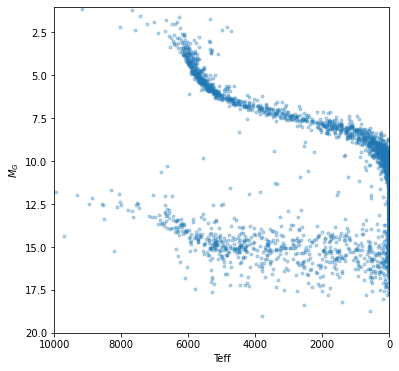

In [11]:
# This is the plot with temperature. Why does it go to zero? KLM does not know. A question to look into. 

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(Teff, M_G.value, 
        marker='.', linestyle='none', alpha=0.3)

ax.set_xlim(10000, 0)
ax.set_ylim(20, 1)

ax.set_xlabel('Teff')
ax.set_ylabel('$M_G$')

In the above, there is a wide range of main sequence star masses which have a range of lifetimes. This same is a a random selection of stars near to the Sun. 

Let's try to pick out a star cluster instead and see how the HR diagram differs. To do this we can select on the RA, Dec and distance of a known cluster. For example let's pick M45 (the Pleaides). Astropy can be used to find it's co-ordinates. Cool huh! It doesn't know it's distance, but I can look it up and it's about 135 pc. 

In [12]:
m45 = SkyCoord.from_name('M45')
m45dist=135 #Distance in pc
m45

<SkyCoord (ICRS): (ra, dec) in deg
    (56.601, 24.114)>

So we need to know the parallax which correspond to 135pc. Recall that the definition of a parsec is the distance at which a star has a 1 arcsecond parallax, and parallax, $p \propto 1/d$. So in arcseconds and parsecs we just have $p = 1/d$, so the parallax of stars in M13 is $p = 1/135$. It looks like Gaia has parallax in mas (milli-arcseconds) so we will multiple by this by 1000 to convert from arcseconds to mas. 

In [13]:
p = 1000/m45dist
p

7.407407407407407

You can't just pick out stars with exactly these values though - you need to choose a reasonable range. The below was based on the [Cone search example published by Gaia  https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries#ADQLQueryExamples] (KLM note: I NEVER remember SQL queries, I always work them out based on examples! Also I had to look up the rough angular scale of Pleiades which I did on Wikipedia, because it worked). 

In [14]:
query_text = '''SELECT TOP 4096 ra, dec, parallax, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr3.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 6 AND parallax < 10 AND
    1 = CONTAINS(
    POINT(56.601, 24.114),
    CIRCLE(ra, dec, 100./60.))
    
ORDER BY random_index
'''

In [15]:
job = Gaia.launch_job(query_text)
m45_data = job.get_results()
#gaia_data.write('gaia_data.fits',overwrite=True) #Use this if you want to save the data to a fits file for later use

In [16]:
m45_data[:4]

ra,dec,parallax,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mas,mag,mag,mag
float64,float64,float64,float32,float32,float32
57.3008750959372,23.886587601561303,7.417763214315631,8.101668,8.198534,7.902198
56.52195568292751,22.981419243413214,7.602128024288136,13.413954,14.269874,12.5023365
57.40227687241278,24.30373739744004,7.176475690564863,16.240494,17.818926,15.0179205
56.2865856843926,24.84194865005806,7.377864703423147,15.99179,17.340973,14.727977


Now run some of the data checks above, and plot the histogram of distances and a HR diagram for this cluster. Does it look different? 

In [184]:
# Distances

In [185]:
# Histogram of distances

In [186]:
# Sky plot here

In [187]:
# HR diagram here

Comment on the star cluster HR diagram or other things in here. 

## 3. Your turn: 

Now try this for another star cluster of your choice (e.g. you could try for the double cluster, NGC 869/884 which is the target for the star cluster observing project). 

## 4. Selecting a Sample of Stars

There are many ways to get Gaia data for a list of stars with known RA, Dec, but I think using the  | Gaia Archive [https://gea.esac.esa.int/archive/] may make the most sense. You can use this to upload a file with a list of star positions, and extract a file of equivalent Gaia data. But what then.... and where to get the list of stars from?

Well one way would be to upload a FITS image of a cluster of stars that you have taken using the 16" to https://nova.astrometry.net/. That will output a file like the one I provide here called [corr.fits]. In this file field_ra, field_dec are the RA and Dec of the stars in the field. Notice this also provides FLUX and BACKGROUND. These are fairly rough estimates only (you can do better in AstroImageJ).

To have a quick look at a FITS table file, Topcat [http://www.star.bris.ac.uk/~mbt/topcat/] is awesome, but in python you can use the below bit of code (there's a ton of different ways to read in files in python, use whatever works). 

Here's what I did: 

In [17]:
my_data = QTable.read('corr.fits')
my_data[:4]

field_x,field_y,field_ra,field_dec,index_x,index_y,index_ra,index_dec,index_id,field_id,match_weight,FLUX,BACKGROUND
pixels,pixels,degrees,degrees,pixels,pixels,degrees,degrees,none,none,none,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32
1169.067626953125,3878.19482421875,35.4809643367118,57.24290718360284,1169.154075366897,3878.2880492109607,35.480985310893494,57.24292028043973,0.0,0.0,0.999802516368333,34396.18,61.339844
2129.34765625,3862.768798828125,35.722885858994495,57.24519436266919,2129.4354647211358,3862.4849454821388,35.72291030231395,57.245156100471,29.0,1.0,0.9998319134754285,13649.881,60.822266
1030.136962890625,1401.0250244140625,35.46827836649913,56.9049817551471,1030.5843245926746,1401.2572415078266,35.468388047914345,56.905015581950664,6.0,2.0,0.9998393052175795,6343.4863,61.436035
2546.2138671875,978.3446655273438,35.84964807031118,56.854225849783155,2546.553898249902,978.5175907685052,35.84973141646052,56.85425081712693,28.0,3.0,0.9998291182638064,6264.9414,61.57959


As far I as I can tell, for the Gaia archive search we need a text file with just field_ra and field_dec on a line. You can do that using the below, but you still need to delete the header line. Turns out the Gaia archive doesn't deal well with files! 

Remember if you are running this on a cloud server you will have to download values.dat to your own computer before uploading to the Gaia archive. 

In [18]:
data = Table()
data['ra'] = my_data['field_ra']
data['dec'] = my_data['field_dec']
ascii.write(data, 'values.dat', overwrite=True)

Once you have run this table through the Gaia archive you can Download the file as a FITS table, and then upload to the Jupyter server and read in like the other fits file! 

In [178]:
cluster_data = QTable.read('1666031869976O-result.fits.gz')
cluster_data

source_id,ra,dec,parallax,pmra,pmdec,ruwe,phot_g_mean_mag,bp_rp,radial_velocity,phot_variable_flag,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,teff_gspphot,logg_gspphot,mh_gspphot,distance_gspphot,azero_gspphot,ag_gspphot,ebpminrp_gspphot,target_id,target_ra,target_dec,target_parallax,target_pm_ra,target_pm_dec,target_radial_velocity,epoch,target_separation (deg)
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,bytes13,int32,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,bytes37,float64,float64,float64,float64,float64,float64,float64,float64
458456358355233920,35.48097631632931,57.24291124391237,0.4509166480995217,-0.5813465946430553,-1.2199636173855266,0.9519509,6.234268,0.8735075,-43.68857,VARIABLE,0,True,True,True,True,False,False,True,--,--,--,--,--,--,--,35.4809643367118 57.24290718360284,35.4809643367118,57.24290718360284,0.0,0.0,0.0,0.0,2000.0,7.648615812600053e-06
458414542551436672,35.72290339119256,57.2451476989381,0.3834187096677617,-0.4717780686625506,-0.9226753968519903,1.0731919,7.220189,1.0628777,-50.215904,VARIABLE,0,True,True,True,True,False,False,True,--,--,--,--,--,--,--,35.722885858994495 57.24519436266919,35.722885858994495,57.24519436266919,0.0,0.0,0.0,0.0,2000.0,4.761809083795108e-05
458310054588240384,35.46838111599417,56.90499528764688,0.4229992423295297,-0.3523134425580261,-3.0620849480065218,1.0130534,8.438903,0.25936985,--,NOT_AVAILABLE,0,True,True,False,False,False,False,True,19693.178,3.2131,0.4105,2397.8354,1.1461,1.1135,0.606,35.46827836649913 56.9049817551471,35.46827836649913,56.9049817551471,0.0,0.0,0.0,0.0,2000.0,5.771317452730337e-05
458388188632487040,35.849755642050084,56.854216405539546,1.4625908787314392,1.8111994247542837,-5.0754119257083765,1.0610237,8.528695,0.24667358,-8.475615,NOT_AVAILABLE,0,True,True,True,False,False,False,True,--,--,--,--,--,--,--,35.84964807031118 56.854225849783155,35.84964807031118,56.854225849783155,0.0,0.0,0.0,0.0,2000.0,5.9570523966479085e-05
458309191287717632,35.293482827845736,56.865644771653464,0.4255593586966089,-0.5451280424244017,-1.17889751269172,0.9305886,8.440851,0.4532547,--,NOT_AVAILABLE,0,True,True,False,False,False,False,True,--,--,--,--,--,--,--,35.29350222908608 56.865670547793236,35.29350222908608,56.865670547793236,0.0,0.0,0.0,0.0,2000.0,2.787240682153426e-05
458406807309355520,35.68273900125866,57.08581402693817,0.46589522604054623,-0.7198505600109951,-1.1289063496553924,1.724426,12.3479,0.5201731,--,NOT_AVAILABLE,0,False,False,False,False,False,True,True,6395.996,3.2143,-4.1066,1887.7323,0.0513,0.0449,0.0246,35.68135492256153 57.086811632725734,35.68135492256153,57.086811632725734,0.0,0.0,0.0,0.0,2000.0,0.0012493327289107524
458406811600345728,35.68223033773895,57.08599997515453,0.5541233997915982,-0.7407744647992747,-1.3190181476686176,3.2685668,12.700873,--,--,NOT_AVAILABLE,0,False,False,False,False,False,False,False,--,--,--,--,--,--,--,35.68135492256153 57.086811632725734,35.68135492256153,57.086811632725734,0.0,0.0,0.0,0.0,2000.0,0.0009407747507330082
458406811610473088,35.681361639184786,57.086797478870224,0.4146023596798115,-0.5577182486586546,-1.2249949693573177,0.9871665,9.1577015,0.45543957,--,NOT_AVAILABLE,0,True,True,False,False,False,False,True,--,--,--,--,--,--,--,35.68135492256153 57.086811632725734,35.68135492256153,57.086811632725734,0.0,0.0,0.0,0.0,2000.0,1.4616811642513324e-05
458423098127529088,36.163584605706625,57.216528243807154,2.0244457655736685,9.694029299733705,-5.290646639536675,1.1848093,9.443136,0.28987122,-14.495151,NOT_AVAILABLE,0,True,True,False,False,False,False,True,--,--,--,--,--,--,--,36.163379627850965 57.21645166013311,36.163379627850965,57.21645166013311,0.0,0.0,0.0,0.0,2000.0,0.0001348463099658698


The simplest query returns lines without any parallax values - you can try to fix that in the query page (e.g. add a condition that the parallax < 100 or something which insists its a number), or filter out those values here. 

I tried the latter and got a new results file: 

In [154]:
cluster_data = QTable.read('1666033137542O-result.fits.gz')
cluster_data

source_id,ra,dec,parallax,pmra,pmdec,ruwe,phot_g_mean_mag,bp_rp,radial_velocity,phot_variable_flag,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,teff_gspphot,logg_gspphot,mh_gspphot,distance_gspphot,azero_gspphot,ag_gspphot,ebpminrp_gspphot,target_id,target_ra,target_dec,target_parallax,target_pm_ra,target_pm_dec,target_radial_velocity
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,bytes13,int32,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,bytes37,float64,float64,float64,float64,float64,float64
458456358355233920,35.48097631632931,57.24291124391237,0.4509166480995217,-0.5813465946430553,-1.2199636173855266,0.9519509,6.234268,0.8735075,-43.68857,VARIABLE,0,True,True,True,True,False,False,True,--,--,--,--,--,--,--,35.4809643367118 57.24290718360284,35.4809643367118,57.24290718360284,0.0,0.0,0.0,0.0
458414542551436672,35.72290339119256,57.2451476989381,0.3834187096677617,-0.4717780686625506,-0.9226753968519903,1.0731919,7.220189,1.0628777,-50.215904,VARIABLE,0,True,True,True,True,False,False,True,--,--,--,--,--,--,--,35.722885858994495 57.24519436266919,35.722885858994495,57.24519436266919,0.0,0.0,0.0,0.0
458310054588240384,35.46838111599417,56.90499528764688,0.4229992423295297,-0.3523134425580261,-3.0620849480065218,1.0130534,8.438903,0.25936985,--,NOT_AVAILABLE,0,True,True,False,False,False,False,True,19693.178,3.2131,0.4105,2397.8354,1.1461,1.1135,0.606,35.46827836649913 56.9049817551471,35.46827836649913,56.9049817551471,0.0,0.0,0.0,0.0
458388188632487040,35.849755642050084,56.854216405539546,1.4625908787314392,1.8111994247542837,-5.0754119257083765,1.0610237,8.528695,0.24667358,-8.475615,NOT_AVAILABLE,0,True,True,True,False,False,False,True,--,--,--,--,--,--,--,35.84964807031118 56.854225849783155,35.84964807031118,56.854225849783155,0.0,0.0,0.0,0.0
458309191287717632,35.293482827845736,56.865644771653464,0.4255593586966089,-0.5451280424244017,-1.17889751269172,0.9305886,8.440851,0.4532547,--,NOT_AVAILABLE,0,True,True,False,False,False,False,True,--,--,--,--,--,--,--,35.29350222908608 56.865670547793236,35.29350222908608,56.865670547793236,0.0,0.0,0.0,0.0
458406807309355520,35.68273900125866,57.08581402693817,0.46589522604054623,-0.7198505600109951,-1.1289063496553924,1.724426,12.3479,0.5201731,--,NOT_AVAILABLE,0,False,False,False,False,False,True,True,6395.996,3.2143,-4.1066,1887.7323,0.0513,0.0449,0.0246,35.68135492256153 57.086811632725734,35.68135492256153,57.086811632725734,0.0,0.0,0.0,0.0
458406811600345728,35.68223033773895,57.08599997515453,0.5541233997915982,-0.7407744647992747,-1.3190181476686176,3.2685668,12.700873,--,--,NOT_AVAILABLE,0,False,False,False,False,False,False,False,--,--,--,--,--,--,--,35.68135492256153 57.086811632725734,35.68135492256153,57.086811632725734,0.0,0.0,0.0,0.0
458406811610473088,35.681361639184786,57.086797478870224,0.4146023596798115,-0.5577182486586546,-1.2249949693573177,0.9871665,9.1577015,0.45543957,--,NOT_AVAILABLE,0,True,True,False,False,False,False,True,--,--,--,--,--,--,--,35.68135492256153 57.086811632725734,35.68135492256153,57.086811632725734,0.0,0.0,0.0,0.0
458423098127529088,36.163584605706625,57.216528243807154,2.0244457655736685,9.694029299733705,-5.290646639536675,1.1848093,9.443136,0.28987122,-14.495151,NOT_AVAILABLE,0,True,True,False,False,False,False,True,--,--,--,--,--,--,--,36.163379627850965 57.21645166013311,36.163379627850965,57.21645166013311,0.0,0.0,0.0,0.0


But it still has bad values. So the below is a better option. 

In [179]:
cluster_data = cluster_data[(cluster_data['parallax']>0)]
cluster_data

source_id,ra,dec,parallax,pmra,pmdec,ruwe,phot_g_mean_mag,bp_rp,radial_velocity,phot_variable_flag,non_single_star,has_xp_continuous,has_xp_sampled,has_rvs,has_epoch_photometry,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,teff_gspphot,logg_gspphot,mh_gspphot,distance_gspphot,azero_gspphot,ag_gspphot,ebpminrp_gspphot,target_id,target_ra,target_dec,target_parallax,target_pm_ra,target_pm_dec,target_radial_velocity,epoch,target_separation (deg)
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,bytes13,int32,bool,bool,bool,bool,bool,bool,bool,float32,float32,float32,float32,float32,float32,float32,bytes37,float64,float64,float64,float64,float64,float64,float64,float64
458456358355233920,35.48097631632931,57.24291124391237,0.4509166480995217,-0.5813465946430553,-1.2199636173855266,0.9519509,6.234268,0.8735075,-43.68857,VARIABLE,0,True,True,True,True,False,False,True,--,--,--,--,--,--,--,35.4809643367118 57.24290718360284,35.4809643367118,57.24290718360284,0.0,0.0,0.0,0.0,2000.0,7.648615812600053e-06
458414542551436672,35.72290339119256,57.2451476989381,0.3834187096677617,-0.4717780686625506,-0.9226753968519903,1.0731919,7.220189,1.0628777,-50.215904,VARIABLE,0,True,True,True,True,False,False,True,--,--,--,--,--,--,--,35.722885858994495 57.24519436266919,35.722885858994495,57.24519436266919,0.0,0.0,0.0,0.0,2000.0,4.761809083795108e-05
458310054588240384,35.46838111599417,56.90499528764688,0.4229992423295297,-0.3523134425580261,-3.0620849480065218,1.0130534,8.438903,0.25936985,--,NOT_AVAILABLE,0,True,True,False,False,False,False,True,19693.178,3.2131,0.4105,2397.8354,1.1461,1.1135,0.606,35.46827836649913 56.9049817551471,35.46827836649913,56.9049817551471,0.0,0.0,0.0,0.0,2000.0,5.771317452730337e-05
458388188632487040,35.849755642050084,56.854216405539546,1.4625908787314392,1.8111994247542837,-5.0754119257083765,1.0610237,8.528695,0.24667358,-8.475615,NOT_AVAILABLE,0,True,True,True,False,False,False,True,--,--,--,--,--,--,--,35.84964807031118 56.854225849783155,35.84964807031118,56.854225849783155,0.0,0.0,0.0,0.0,2000.0,5.9570523966479085e-05
458309191287717632,35.293482827845736,56.865644771653464,0.4255593586966089,-0.5451280424244017,-1.17889751269172,0.9305886,8.440851,0.4532547,--,NOT_AVAILABLE,0,True,True,False,False,False,False,True,--,--,--,--,--,--,--,35.29350222908608 56.865670547793236,35.29350222908608,56.865670547793236,0.0,0.0,0.0,0.0,2000.0,2.787240682153426e-05
458406807309355520,35.68273900125866,57.08581402693817,0.46589522604054623,-0.7198505600109951,-1.1289063496553924,1.724426,12.3479,0.5201731,--,NOT_AVAILABLE,0,False,False,False,False,False,True,True,6395.996,3.2143,-4.1066,1887.7323,0.0513,0.0449,0.0246,35.68135492256153 57.086811632725734,35.68135492256153,57.086811632725734,0.0,0.0,0.0,0.0,2000.0,0.0012493327289107524
458406811600345728,35.68223033773895,57.08599997515453,0.5541233997915982,-0.7407744647992747,-1.3190181476686176,3.2685668,12.700873,--,--,NOT_AVAILABLE,0,False,False,False,False,False,False,False,--,--,--,--,--,--,--,35.68135492256153 57.086811632725734,35.68135492256153,57.086811632725734,0.0,0.0,0.0,0.0,2000.0,0.0009407747507330082
458406811610473088,35.681361639184786,57.086797478870224,0.4146023596798115,-0.5577182486586546,-1.2249949693573177,0.9871665,9.1577015,0.45543957,--,NOT_AVAILABLE,0,True,True,False,False,False,False,True,--,--,--,--,--,--,--,35.68135492256153 57.086811632725734,35.68135492256153,57.086811632725734,0.0,0.0,0.0,0.0,2000.0,1.4616811642513324e-05
458423098127529088,36.163584605706625,57.216528243807154,2.0244457655736685,9.694029299733705,-5.290646639536675,1.1848093,9.443136,0.28987122,-14.495151,NOT_AVAILABLE,0,True,True,False,False,False,False,True,--,--,--,--,--,--,--,36.163379627850965 57.21645166013311,36.163379627850965,57.21645166013311,0.0,0.0,0.0,0.0,2000.0,0.0001348463099658698


Annoyingly the file the Gaia Archive query returns does not attach units to the columns. Anyway, that means you have to modify the code to set up distances and co-ordinates a bit to tell it about units. This is what I did. 

In [180]:
mydist = (1000.0/cluster_data['parallax'])*u.parsec
#mydist = coord.Distance(cluster_data['parallax']*u.mas)

mydist=coord.Distance(mydist)
mydist.min(), mydist.max()


(<Distance 151.98071711 pc>, <Distance 3257.47402573 pc>)

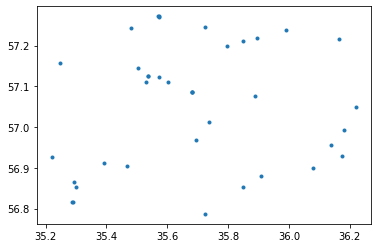

In [181]:
# You have to tell it the units though because the Gaia archive doesn't output Astropy quantities. 
c = coord.SkyCoord(ra=cluster_data['ra']*u.degree, 
                   dec=cluster_data['dec']*u.degree,
                   distance=mydist, frame='icrs')

#Here's a really quick sky plot. 
plt.plot(c.ra, c.dec,'.')

We'll make a HR diagram now with all the Gaia stars in the first query, in M45 and the ones in our own data overplotted. 

Be careful - I wrote this Notebook to keep gaia_data as containing the data from the first query, and m45_data as the data from m45. Did you change variable names? 


Text(0, 0.5, '$M_G$')

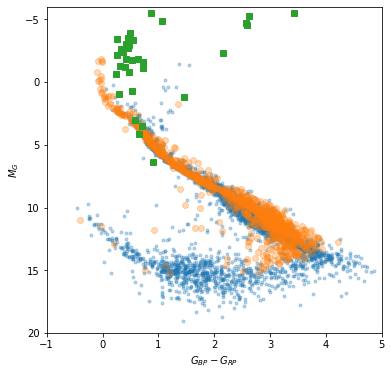

In [182]:
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']

M_G1 = m45_data['phot_g_mean_mag'] - m45dist.distmod
BP_RP1 = m45_data['phot_bp_mean_mag'] - m45_data['phot_rp_mean_mag']

M_G2 = cluster_data['phot_g_mean_mag']*u.mag - mydist.distmod
BP_RP2 = cluster_data['bp_rp']*u.mag

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(BP_RP.value, M_G.value, 
        marker='.', linestyle='none', alpha=0.3)

ax.plot(BP_RP1.value, M_G1.value, 
        marker='o', linestyle='none', alpha=0.3)

ax.plot(BP_RP2.value, M_G2.value, 
        marker='s', linestyle='none', alpha=1.0)

ax.set_xlim(-1, 5)
ax.set_ylim(20, -6)

ax.set_xlabel('$G_{BP}-G_{RP}$')
ax.set_ylabel('$M_G$')


Comment on the HR diagram here. 


For the star cluster project you will try to do your own B and V-band photometry of these stars (hopefully more than I got here), so you can be a V-band vs. B-V version of a colour magnitude diagram, as well as this kind. 

You might also play with filter transformations. 

## Recap 

In this tutorial, we've used `astroquery` to query the Gaia science archive to retrieve parallaxes and photometric data for various samples of stars with well-measured parallaxes from Gaia DR2. 

We also talked about cross matching with Gaia and what to do with the output file you get. 


## HW Assignment

I don't want you to turn in any code, or the comments you put in above. Instead make a document with at least seven different plots you have generated by either running the code above, or modifying it. In the document you should also put words which explain what the plots show, including what the data points are, explaining the axes etc. You might like to use the comments you wrote as you went along.  

At least one plot should come from each numbered section above, the others are your choice. 